# Sport Ball Recognition

กลุ่ม JaJa

*   ณัฐเมธี จันทร์นิธิกุล 63070223
*   ธนธรณ์ หอมชิต 63070225
*   ธนภัทร ธีรรัตตัญญู 63070227
*   รมิตา ศรีภูธร 63070240
*   ศิรา อัตตวนิช 63070243

# Import Data

In [1]:
import numpy as np

data_X = np.load('train_X.npy')
data_Y = np.load('train_Y.npy')

In [2]:
print(data_X.shape)
print(data_Y.shape)

(4482, 224, 224, 3)
(4482,)


In [3]:
import seaborn as sns
import matplotlib.pylab as plt

Text(0.5, 1.0, 'Sport Balls')

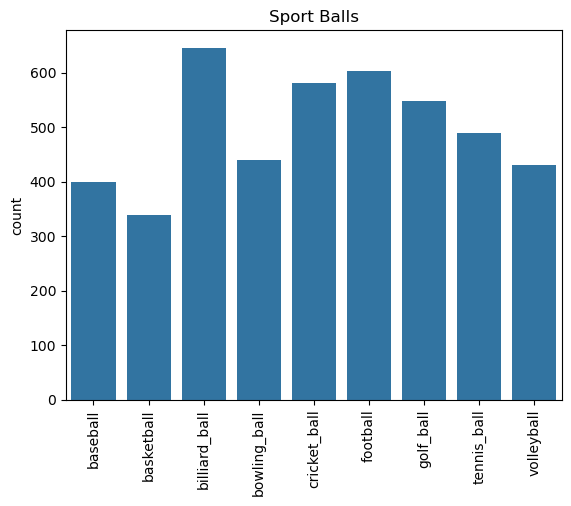

In [4]:
g = sns.countplot(x=data_Y)
plt.xticks(rotation=90)
plt.title('Sport Balls')

In [5]:
np.unique(data_Y, return_counts=True)

(array(['baseball', 'basketball', 'billiard_ball', 'bowling_ball',
        'cricket_ball', 'football', 'golf_ball', 'tennis_ball',
        'volleyball'], dtype='<U13'),
 array([400, 340, 646, 440, 581, 604, 549, 490, 432], dtype=int64))

# Encode Label

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data_Y)
data_Y_encoded = le.transform(data_Y)

In [7]:
data_Y_encoded

array([0, 0, 0, ..., 8, 8, 8])

In [8]:
data_Y_encoded.shape

(4482,)

# Prepare Data

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

In [10]:
train0_X, test_X, train0_Y, test_Y = train_test_split(data_X, data_Y_encoded, test_size=0.3, random_state=42)

In [11]:
train_X, val_X, train_Y, val_Y = train_test_split(train0_X, train0_Y, test_size=0.3, random_state=42)

In [12]:
np.unique(test_Y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([129,  99, 205, 133, 170, 173, 150, 148, 138], dtype=int64))

In [13]:
train_X[0].shape

(224, 224, 3)

# Data Augementation

In [15]:
import tensorflow

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
              rotation_range=10, # rotation
              width_shift_range=0.2, # horizontal shift
              height_shift_range=0.2, # vertical shift
              zoom_range=0.2, # zoom
              horizontal_flip=True, # horizontal flip
              vertical_flip=True, # vertical flip
              brightness_range=[0.2,1.2] # brightness
          )

In [17]:
augmented = datagen.flow(train_X, train_Y, batch_size=32, seed=42)

In [18]:
import cv2
img = cv2.cvtColor(augmented[1][0][5], cv2.COLOR_BGR2RGB)


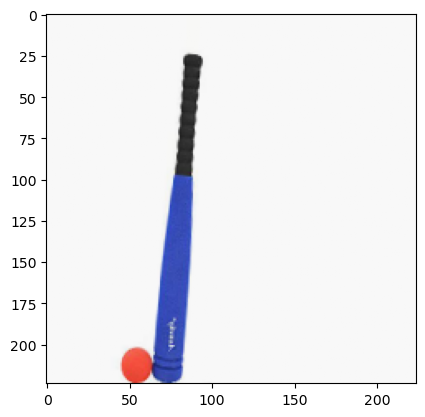

In [19]:
plt.imshow(img/255)

# Architecture 1

In [20]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [21]:
base_model = tf.keras.applications.EfficientNetV2B3(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=(224, 224, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.25, noise_shape=None, seed=42)(x)
x = Dense(64, activation='relu')(x)

# and a logistic layer
predictions = Dense(14, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
callback_mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/classfication ball/EfficientNetV2B3_best_weight.h5', save_best_only=True, monitor='val_accuracy', mode='max')


model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(datagen.flow(train_X, train_Y, batch_size=8, seed=42),
          epochs=30, callbacks=[callback_early, callback_mcp_save], validation_data=(val_X, val_Y))

Epoch 1/30
275/275 [==============================] - 78s 187ms/step - loss: 1.7543 - accuracy: 0.4446 - val_loss: 1.0436 - val_accuracy: 0.6688
Epoch 2/30
275/275 [==============================] - 45s 163ms/step - loss: 1.3503 - accuracy: 0.5695 - val_loss: 1.0514 - val_accuracy: 0.6762
Epoch 3/30
275/275 [==============================] - 45s 163ms/step - loss: 1.1954 - accuracy: 0.6105 - val_loss: 0.8085 - val_accuracy: 0.7580
Epoch 4/30
275/275 [==============================] - 43s 157ms/step - loss: 1.0781 - accuracy: 0.6569 - val_loss: 0.9312 - val_accuracy: 0.7144
Epoch 5/30
275/275 [==============================] - 45s 163ms/step - loss: 1.0022 - accuracy: 0.6875 - val_loss: 0.6744 - val_accuracy: 0.8057
Epoch 6/30
275/275 [==============================] - 44s 159ms/step - loss: 0.8650 - accuracy: 0.7244 - val_loss: 0.8100 - val_accuracy: 0.7335
Epoch 7/30
275/275 [==============================] - 44s 158ms/step - loss: 0.8247 - accuracy: 0.7508 - val_loss: 0.8831 - val_ac

In [23]:
model.load_weights('/content/drive/MyDrive/classfication ball/EfficientNetV2B3_best_weight.h5')

pred = model.predict(test_X)
pred = np.argmax(pred, axis=1)
pred

43/43 [==============================] - 8s 140ms/step


array([0, 7, 2, ..., 7, 0, 1], dtype=int64)

In [24]:
from sklearn.metrics import accuracy_score
accuracy_score(test_Y, pred)

0.820817843866171

In [25]:
import matplotlib.pyplot as plt

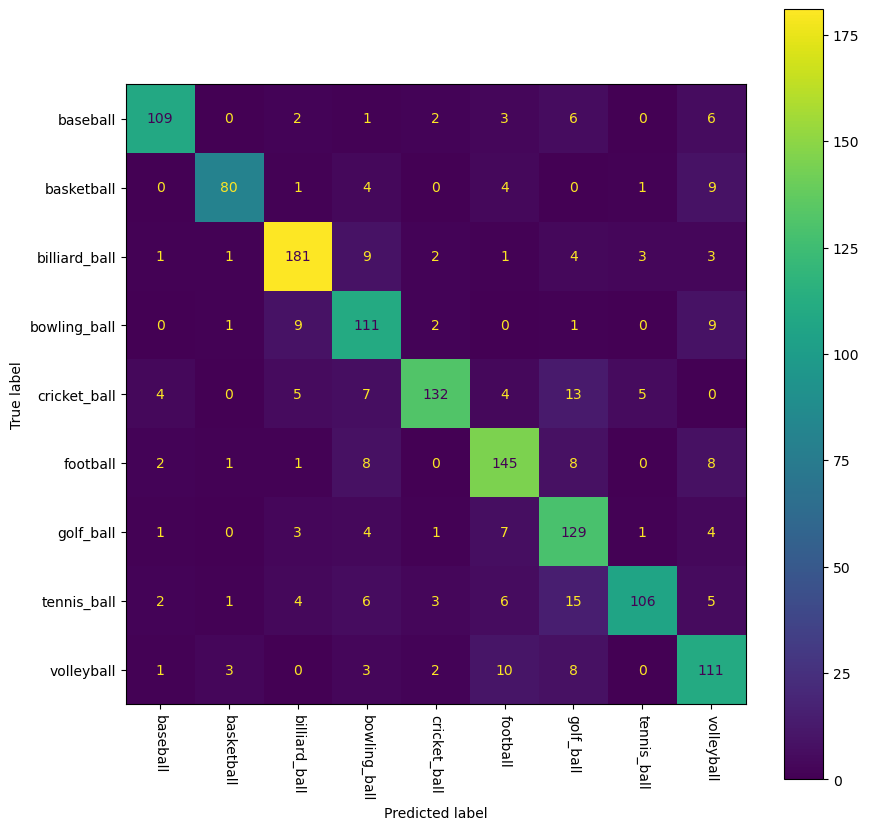

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.xticks(rotation=270)
plt.show()

In [27]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Architecture 2

In [28]:
base_model = tf.keras.applications.EfficientNetV2B3(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=(224, 224, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25, noise_shape=None, seed=42)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25, noise_shape=None, seed=42)(x)
x = Dense(512, activation='relu')(x)

# and a logistic layer
predictions = Dense(14, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [30]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
callback_mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/classfication ball/EfficientNetV2B3_2_best_weight.h5', save_best_only=True, monitor='val_accuracy', mode='max')


model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(datagen.flow(train_X, train_Y, batch_size=8, seed=42),
          epochs=30, callbacks=[callback_early, callback_mcp_save], validation_data=(val_X, val_Y))

Epoch 1/30
275/275 [==============================] - 63s 175ms/step - loss: 1.7583 - accuracy: 0.4260 - val_loss: 1.3236 - val_accuracy: 0.6072
Epoch 2/30
275/275 [==============================] - 45s 163ms/step - loss: 1.5604 - accuracy: 0.4948 - val_loss: 1.3940 - val_accuracy: 0.6062
Epoch 3/30
275/275 [==============================] - 50s 182ms/step - loss: 1.3633 - accuracy: 0.5636 - val_loss: 1.0839 - val_accuracy: 0.6837
Epoch 4/30
275/275 [==============================] - 45s 165ms/step - loss: 1.3007 - accuracy: 0.5941 - val_loss: 1.8419 - val_accuracy: 0.5297
Epoch 5/30
275/275 [==============================] - 46s 166ms/step - loss: 1.2101 - accuracy: 0.6296 - val_loss: 0.7467 - val_accuracy: 0.7771
Epoch 6/30
275/275 [==============================] - 47s 170ms/step - loss: 1.0618 - accuracy: 0.6793 - val_loss: 0.7100 - val_accuracy: 0.7919
Epoch 7/30
275/275 [==============================] - 44s 161ms/step - loss: 0.9961 - accuracy: 0.7034 - val_loss: 0.7633 - val_ac

In [ ]:
model.load_weights('/content/drive/MyDrive/classfication ball/EfficientNetV2B3_2_best_weight.h5')

pred = model.predict(test_X)
pred = np.argmax(pred, axis=1)
pred

array([ 3,  3,  3,  3,  8,  9,  9,  6,  1,  1,  0,  2,  3,  1,  7, 11,  4,
        4,  9,  6,  0,  4, 11,  5,  9,  3, 12, 13,  3,  1, 10,  6, 10,  5,
        5,  6,  5,  1,  3,  3, 13,  0,  1,  7,  4, 13, 12,  6,  7,  1,  5,
       10,  5,  7,  8, 10, 13, 12, 13,  2,  0,  1,  6, 12,  9,  2,  2,  9,
       13,  5,  5,  8,  7, 13, 10,  0, 10,  8, 13,  9,  8, 12,  8,  4,  8,
       11,  7, 13,  8, 13,  8,  3,  9,  9,  3, 12, 10,  9,  4, 11,  9,  4,
        7,  3,  8,  9,  4,  5,  4,  5,  5,  6, 13,  3,  5,  5,  2,  3,  2,
        6,  7,  3,  5,  0,  1,  4, 12,  4, 12,  8,  4,  9,  2,  2, 13,  1,
        0,  3,  8,  0,  0,  6,  4, 10,  3,  3,  3,  9,  2,  4,  2,  0, 11,
        8, 11, 13,  3,  8,  5,  0,  8, 13,  1, 12, 10,  0,  5,  6,  2,  5,
        1,  7,  1,  4,  7, 13,  4,  5, 12, 12,  0,  8,  3,  3,  4,  7,  8,
        1,  4,  7, 13,  0, 10,  6,  9,  6,  8,  0,  9,  4,  3,  8,  3,  5,
       13, 13,  1,  6, 12,  9,  3,  4, 13, 13,  3,  4,  2,  7,  3,  3, 12,
       12, 11,  9, 12,  2

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_Y, pred)

0.9032258064516129

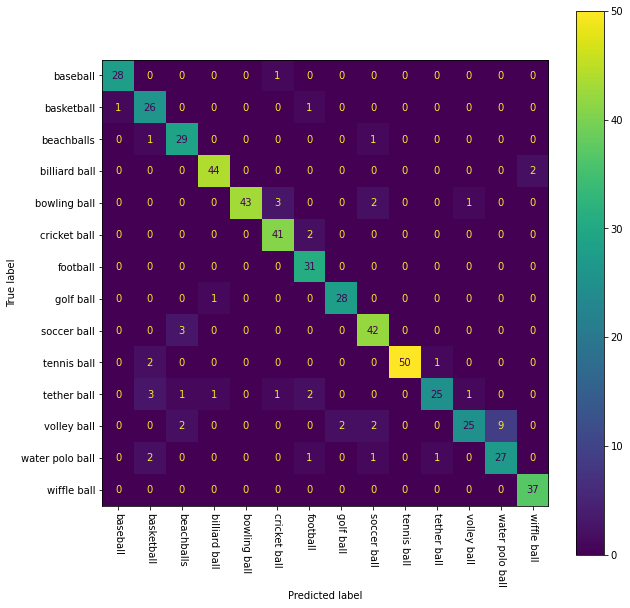

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.xticks(rotation=270)
plt.show()

# Architecture 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=(224, 224, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.25, noise_shape=None, seed=42)(x)
x = Dense(64, activation='relu')(x)

# and a logistic layer
predictions = Dense(14, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
callback_mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/classfication ball/InceptionV3_best_weight.h5', save_best_only=True, monitor='val_accuracy', mode='max')


model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(datagen.flow(train_X, train_Y, batch_size=32, seed=42),
          epochs=30, callbacks=[callback_early, callback_mcp_save], validation_data=(val_X, val_Y))

Epoch 1/30
27/27 [==============================] - 31s 777ms/step - loss: 1.6694 - accuracy: 0.5012 - val_loss: 36.5231 - val_accuracy: 0.0840
Epoch 2/30
27/27 [==============================] - 16s 603ms/step - loss: 1.3717 - accuracy: 0.6407 - val_loss: 18.4470 - val_accuracy: 0.1030
Epoch 3/30
27/27 [==============================] - 15s 562ms/step - loss: 1.0359 - accuracy: 0.7140 - val_loss: 2.5731 - val_accuracy: 0.2304
Epoch 4/30
27/27 [==============================] - 14s 496ms/step - loss: 0.8630 - accuracy: 0.7709 - val_loss: 4.2073 - val_accuracy: 0.1382
Epoch 5/30
27/27 [==============================] - 20s 727ms/step - loss: 0.7559 - accuracy: 0.7977 - val_loss: 3.1689 - val_accuracy: 0.3794
Epoch 6/30
27/27 [==============================] - 15s 568ms/step - loss: 0.5906 - accuracy: 0.8360 - val_loss: 3.1131 - val_accuracy: 0.5257
Epoch 7/30
27/27 [==============================] - 15s 566ms/step - loss: 0.6456 - accuracy: 0.8314 - val_loss: 2.1328 - val_accuracy: 0.62

In [ ]:
model.load_weights('/content/drive/MyDrive/classfication ball/InceptionV3_best_weight.h5')

pred = model.predict(test_X)
pred = np.argmax(pred, axis=1)
pred

array([ 4,  3,  3,  2,  2,  7,  7,  6, 10,  9,  0,  2,  3,  1,  7, 11, 10,
        4,  9,  6, 11,  4, 12,  8,  9,  2,  1, 13,  3, 10, 12,  1,  1,  4,
        5,  6,  6,  1,  3,  2, 13,  7,  6, 10,  4, 13, 12,  6, 10,  1, 10,
        2,  5,  7,  2, 12,  4, 12, 13,  2,  0,  1,  6, 12, 12,  2,  2,  9,
       13,  5,  2, 10,  7, 13, 10,  0, 10,  2, 13,  7,  2, 12, 10,  4,  2,
       11,  7, 13,  2, 13,  8,  4,  2,  7,  3,  2, 12,  9,  4,  2,  2,  4,
       11,  3,  2,  9,  4,  5, 10,  5, 10,  6,  2,  1,  2,  5,  2,  3,  2,
        1,  7,  3,  6,  0,  2,  4, 12,  4,  1,  8,  4,  9,  2,  2, 13, 12,
        7,  2, 10,  0,  0,  6,  4,  2,  3,  3,  3,  9,  2,  4,  2,  0, 11,
        1, 11,  4,  3,  2, 10,  2,  2, 13,  1, 12, 12,  6,  2,  6,  2,  4,
        1,  7,  1,  4,  7, 11,  2,  2, 12, 12,  0,  2,  3,  2,  4,  7,  2,
        1,  4,  7, 13,  0,  2,  6,  9,  6,  2,  0,  2,  4,  3,  2,  3,  5,
        2, 10, 12,  6, 12,  6,  2,  4, 10,  4,  3,  4,  2,  7, 11,  3, 12,
       12,  2,  9, 12,  2

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_Y, pred)

0.5958254269449715

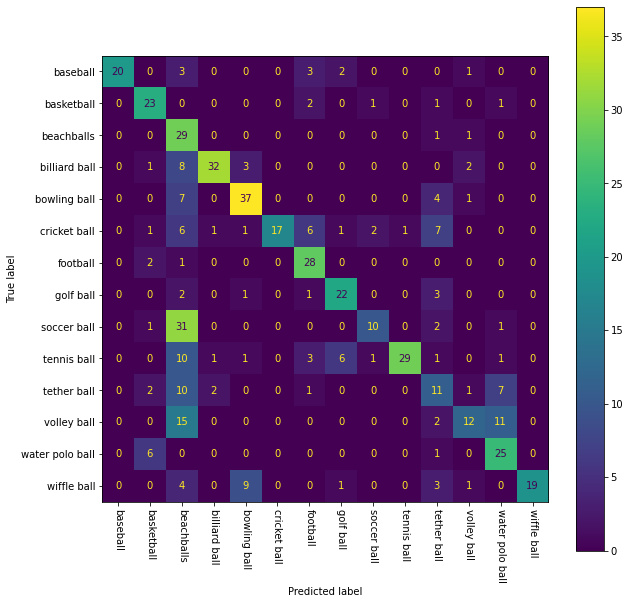

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.xticks(rotation=270)
plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Architecture 4

In [ ]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet',
                                                    include_top=False,
                                                    input_shape=(224, 224, 3))

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25, noise_shape=None, seed=42)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25, noise_shape=None, seed=42)(x)
x = Dense(512, activation='relu')(x)

# and a logistic layer
predictions = Dense(14, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
callback_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
callback_mcp_save = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/classfication ball/InceptionV3_2_best_weight.h5', save_best_only=True, monitor='val_accuracy', mode='max')


model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.fit(datagen.flow(train_X, train_Y, batch_size=32, seed=42),
          epochs=30, callbacks=[callback_early, callback_mcp_save], validation_data=(val_X, val_Y))

Epoch 1/30
27/27 [==============================] - 25s 648ms/step - loss: 1.9096 - accuracy: 0.4512 - val_loss: 94.8743 - val_accuracy: 0.0786
Epoch 2/30
27/27 [==============================] - 14s 502ms/step - loss: 1.4024 - accuracy: 0.5953 - val_loss: 122.9706 - val_accuracy: 0.0542
Epoch 3/30
27/27 [==============================] - 13s 492ms/step - loss: 1.2996 - accuracy: 0.6209 - val_loss: 17.0117 - val_accuracy: 0.0623
Epoch 4/30
27/27 [==============================] - 18s 664ms/step - loss: 1.0624 - accuracy: 0.7081 - val_loss: 5.0240 - val_accuracy: 0.1491
Epoch 5/30
27/27 [==============================] - 16s 582ms/step - loss: 0.8590 - accuracy: 0.7384 - val_loss: 4.1268 - val_accuracy: 0.1951
Epoch 6/30
27/27 [==============================] - 17s 611ms/step - loss: 0.7888 - accuracy: 0.7930 - val_loss: 6.4251 - val_accuracy: 0.4661
Epoch 7/30
27/27 [==============================] - 17s 633ms/step - loss: 0.6137 - accuracy: 0.8233 - val_loss: 2.0014 - val_accuracy: 0.

In [ ]:
model.load_weights('/content/drive/MyDrive/classfication ball/InceptionV3_2_best_weight.h5')

pred = model.predict(test_X)
pred = np.argmax(pred, axis=1)
pred

array([ 5,  3,  3,  3,  8,  9,  9,  6, 10,  9,  0,  2,  3,  6, 13, 11,  6,
       10,  9,  6, 11,  4, 11,  5,  9,  3, 12, 13,  3,  1, 10,  8, 10,  6,
        5,  6,  0,  1,  3,  3, 13, 11,  1,  7,  4, 13, 12,  6, 10,  1, 10,
       10,  6,  7,  8, 10, 13, 10, 13,  2,  0,  1,  6, 11,  9, 11, 11,  9,
       13,  5,  6,  4,  7, 13, 10,  0, 10,  8, 13,  9,  8, 12,  8,  4,  8,
       11,  7, 13,  8, 13,  8,  3, 10,  9,  8, 11, 10,  9,  4, 11,  9,  6,
       11,  3,  8,  9,  4,  5, 10,  5,  5,  6,  8,  3,  5,  5, 10,  3,  2,
        1, 10,  1,  6,  0,  9, 10, 11, 10, 12,  8, 13,  9,  2,  2, 13, 12,
        0,  3, 11,  0,  0,  6,  4, 10, 13,  3,  3,  9, 11, 13,  8,  0, 11,
        6, 11, 13,  3,  8,  5,  0,  8, 13, 12, 12, 10,  0,  6,  6, 11,  1,
        1,  7,  1, 13,  7, 13,  2,  5, 12, 12,  0,  8,  3,  3, 10,  7,  8,
        1,  4,  7, 13,  0,  9,  6,  9,  6,  8,  0, 13,  6,  3, 11,  3,  5,
       13, 13, 11,  6, 12,  9,  3, 10,  7, 13,  3,  4,  2,  7,  3,  3, 12,
       12, 11,  9, 12,  2

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_Y, pred)

0.7590132827324478

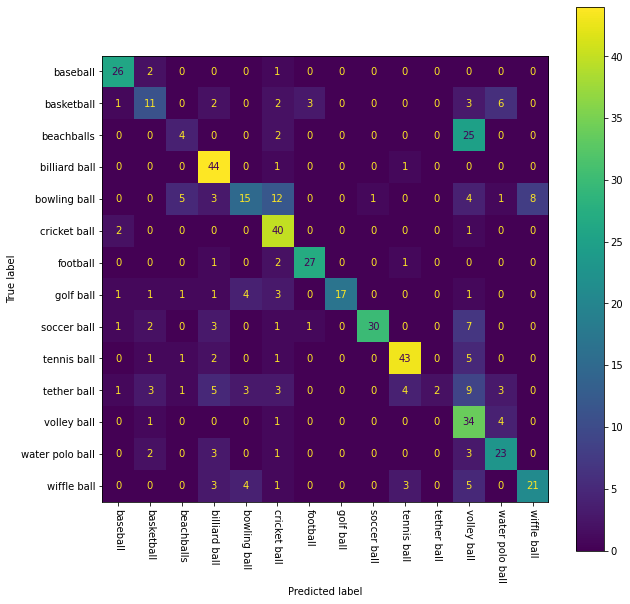

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.xticks(rotation=270)
plt.show()